# Data Mining Coursework 2
## 100276935
This Jupyter Notebook contains code that performs the following operations:
1. Data Exploration, Visualisation, and Summary
2. Data Cleansing and Pre-processing
3. Supervised Model Training, Tuning, and Evaluation
4. Unsupervised Learning using Clustering Algorithms

## Prior setups
Importing the necessary libraries and relevant folder and files.

In [1]:
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
from numpy import nan
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, silhouette_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, normalize
# The types of classifiers to use
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
# Sampling techniques to use
from imblearn.over_sampling import SMOTENC
# Shap for explainable AI
import shap

print("Setup complete.")

data_folder = "data/"
train_data_file = "disease_train.csv"
test_data_file = "disease_test.csv"
prediction_data_file = "predictedTarget.csv"

Setup complete.


Read the CSV files and store the data into a Pandas DataFrame.

In [2]:
train_data = pd.read_csv(data_folder + train_data_file, delimiter=",")
test_data = pd.read_csv(data_folder + test_data_file, delimiter=",")
pred_df = pd.read_csv(data_folder + prediction_data_file, delimiter=",")
print(train_data.head(5))
print(test_data.head(5))

       id  age  gender sick pregnant  test_X1  test_X2  test_X3  test_X4  \
0  PA1001   59    male   no       no      7.8      NaN     89.0     0.85   
1  PA1002   48  female   no       no      1.5      2.5    101.0     0.97   
2  PA1003   77    male   no       no      7.3      1.2     57.0     1.28   
3  PA1004   42  female   no       no      1.2      2.5    106.0     0.98   
4  PA1005   38  female   no       no      0.6      1.9     95.0      NaN   

   test_X5  ...  tumor disorder medication_A medication_B mental_health  \
0    105.0  ...     no       no           no           no            no   
1    104.0  ...     no       no          yes           no            no   
2     44.0  ...     no       no           no           no            no   
3    108.0  ...     no       no           no           no            no   
4      NaN  ...     no       no           no           no            no   

  mood_stabiliser surgery treatment_type1 suspect         target  
0              no      no

## 1. Data Exploration, Visualisation, and Summary
As the data mining procedure mainly involves the training data, most of the operations will be solely done on the training data and the test data will follow suit.

### Get column names
In the cell below, the names of the categorical and numerical columns are obtained and stored in a list. This method avoids writing them down manually. 

`train_data` has a `target` column unlike `test_data` which will not be included in the categorical columns list.

In [3]:
print(f"train_categorical_columns = {list(train_data.select_dtypes(include=['object']).columns)}\n")
print(f"train_numerical_columns = {list(train_data.select_dtypes(include=['int64', 'float64']).columns)}")
print("-----------------------------------------------------------------------------\n")
print(f"test_categorical_columns = {list(test_data.select_dtypes(include=['object']).columns)}\n")
print(f"test_numerical_columns = {list(test_data.select_dtypes(include=['int64', 'float64']).columns)}")
print("-----------------------------------------------------------------------------\n")
categorical_features = list(train_data.select_dtypes(include=["object"]).columns)
# target is not a feature so remove from the list
categorical_features.remove("target")
print(f"categorical_features ({len(categorical_features)}) = {categorical_features}\n")
numerical_features = list(train_data.select_dtypes(include=["int64", "float64"]).columns)
print(f"numerical_features ({len(numerical_features)}) = {numerical_features}\n")

train_categorical_columns = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect', 'target']

train_numerical_columns = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']
-----------------------------------------------------------------------------

test_categorical_columns = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1', 'suspect']

test_numerical_columns = ['age', 'test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5', 'test_X6']
-----------------------------------------------------------------------------

categorical_features (16) = ['id', 'gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'disorder', 'medicati

### Data Summary
Get a statistical summary of the numerical features.

In [4]:
print(f"Train data summary statistics: \n{train_data.describe()}")
print("\n")
print(f"Test data summary statistics: \n{test_data.describe()}")

Train data summary statistics: 
                age      test_X1      test_X2      test_X3      test_X4  \
count   4250.000000  3839.000000  3007.000000  4034.000000  3858.000000   
mean      67.374824     7.342463     2.035580   104.919623     0.970846   
std     1004.518821    32.657963     0.920404    35.496255     0.162474   
min        1.000000     0.005000     0.050000     2.000000     0.250000   
25%       37.000000     0.600000     1.600000    87.000000     0.870000   
50%       55.000000     1.500000     1.900000   102.000000     0.960000   
75%       67.000000     3.000000     2.300000   121.000000     1.060000   
max    65526.000000   530.000000    18.000000   430.000000     1.960000   

           test_X5     test_X6  
count  3863.000000  154.000000  
mean    110.090834   23.325974  
std      39.837621    5.317032  
min       1.400000    8.400000  
25%      92.000000   20.000000  
50%     107.000000   24.000000  
75%     125.000000   27.000000  
max     642.000000   45.0000

### Check Column Data Types and Missing Values
Check the data type of the columns and check how many entries are non-null in the training and test data. 60% of the total entries for each feature have to be non-null in order for a feature to be valid for the train data. 60% of 4250 `train_data` entries is 2550. Looking at the columns, column `test_X6` has less than 2550 entries that are non-null values. Hence, column `text_X6` can be removed from both datasets. 

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               4250 non-null   object 
 1   age              4250 non-null   int64  
 2   gender           4109 non-null   object 
 3   sick             4250 non-null   object 
 4   pregnant         4250 non-null   object 
 5   test_X1          3839 non-null   float64
 6   test_X2          3007 non-null   float64
 7   test_X3          4034 non-null   float64
 8   test_X4          3858 non-null   float64
 9   test_X5          3863 non-null   float64
 10  test_X6          154 non-null    float64
 11  concern_type1    4250 non-null   object 
 12  concern_type2    4250 non-null   object 
 13  enlargement      4250 non-null   object 
 14  tumor            4250 non-null   object 
 15  disorder         4250 non-null   object 
 16  medication_A     4250 non-null   object 
 17  medication_B  

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               750 non-null    object 
 1   age              750 non-null    int64  
 2   gender           724 non-null    object 
 3   sick             750 non-null    object 
 4   pregnant         750 non-null    object 
 5   test_X1          674 non-null    float64
 6   test_X2          542 non-null    float64
 7   test_X3          717 non-null    float64
 8   test_X4          678 non-null    float64
 9   test_X5          679 non-null    float64
 10  test_X6          25 non-null     float64
 11  concern_type1    750 non-null    object 
 12  concern_type2    750 non-null    object 
 13  enlargement      750 non-null    object 
 14  tumor            750 non-null    object 
 15  disorder         750 non-null    object 
 16  medication_A     750 non-null    object 
 17  medication_B    

Count the number of missing data points for each feature. Because `gender` is a categorical feature, the only way to deal with missing values was imputation. `test_X1` to `test_X5` are all numerical columns, allowing the missing values to be imputed in some way.

In [7]:
print("Train Data: ")
print(train_data.isnull().sum())
print("\n")
print("Test Data: ")
print(test_data.isnull().sum())

Train Data: 
id                    0
age                   0
gender              141
sick                  0
pregnant              0
test_X1             411
test_X2            1243
test_X3             216
test_X4             392
test_X5             387
test_X6            4096
concern_type1         0
concern_type2         0
enlargement           0
tumor                 0
disorder              0
medication_A          0
medication_B          0
mental_health         0
mood_stabiliser       0
surgery               0
treatment_type1       0
suspect               0
target                0
dtype: int64


Test Data: 
id                   0
age                  0
gender              26
sick                 0
pregnant             0
test_X1             76
test_X2            208
test_X3             33
test_X4             72
test_X5             71
test_X6            725
concern_type1        0
concern_type2        0
enlargement          0
tumor                0
disorder             0
medication_A    

### Number of unique values
The cell below counts the total occurrances for each value in every column. The column `id` has only unique values and column `disorder` is constant for all entries, meaning that both can be safely removed from the dataset. 

Some columns contains outliers which will need to be preproccessed later like `age` which not only has outrageous outliers. Some columns have highly imbalanced data which will also need to be accounted for.

In [8]:
for column in train_data.columns:
    print(train_data[column].value_counts(), "\n")

PA1001    1
PA3839    1
PA3825    1
PA3826    1
PA3827    1
         ..
PA2423    1
PA2424    1
PA2425    1
PA2426    1
PA5250    1
Name: id, Length: 4250, dtype: int64 

59       100
62        97
60        94
58        93
55        89
        ... 
65526      1
4          1
97         1
455        1
94         1
Name: age, Length: 94, dtype: int64 

female    2787
male      1322
Name: gender, dtype: int64 

no     4095
yes     155
Name: sick, dtype: int64 

no     4235
yes      15
Name: pregnant, dtype: int64 

0.100      117
1.300      109
1.500      106
1.100      104
1.200      104
          ... 
164.000      1
0.255        1
170.000      1
56.000       1
165.000      1
Name: test_X1, Length: 334, dtype: int64 

1.8    237
2.0    231
1.9    223
1.7    209
2.1    191
      ... 
5.6      1
6.4      1
5.4      1
4.8      1
6.9      1
Name: test_X2, Length: 77, dtype: int64 

101.0    91
98.0     81
95.0     78
93.0     78
90.0     71
         ..
359.0     1
18.0      1
27.0      1
218.

### Target Label Distribution Visualisation
The cell below shows the distribution of the train dataset which clearly shows that it is imbalanced. Some prepocessing will need to be done in order to make the data more balanced later.

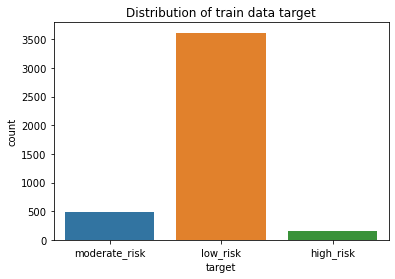

In [9]:
sns.countplot(x='target', data=train_data)
plt.title("Distribution of train data target")
#Save the plot to the working directory
plt.savefig(data_folder + 'target_distribution.jpg')

### Categorical Column Distribution Visualisation
The cell below creates plots showing distribution for almost every column against `target` except `id`, `disorder`, and `target` as they only have unique values, constant values, and same values respectively.

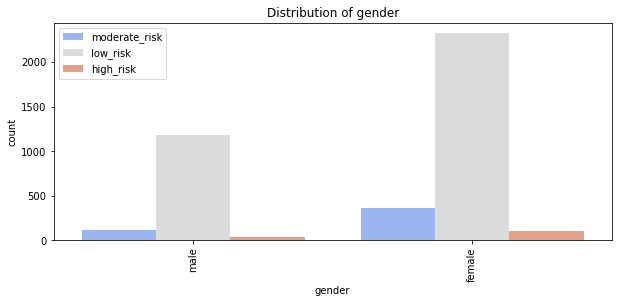

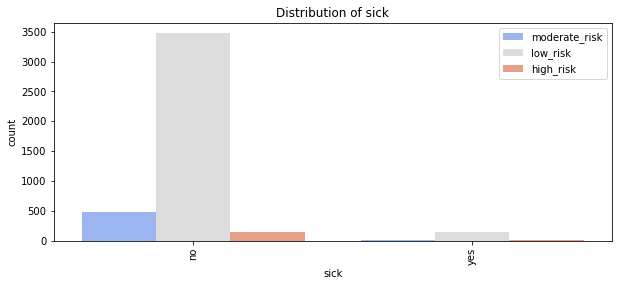

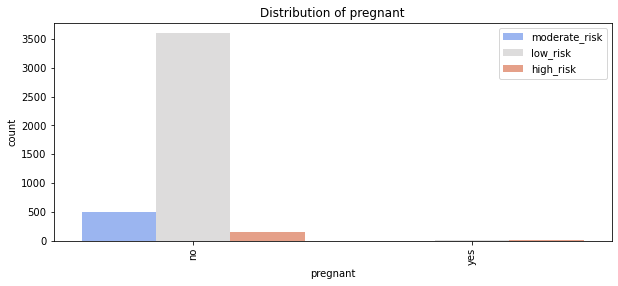

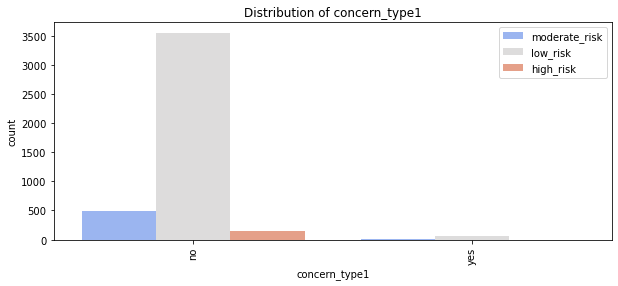

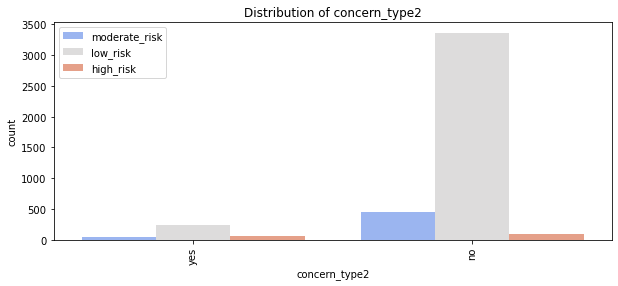

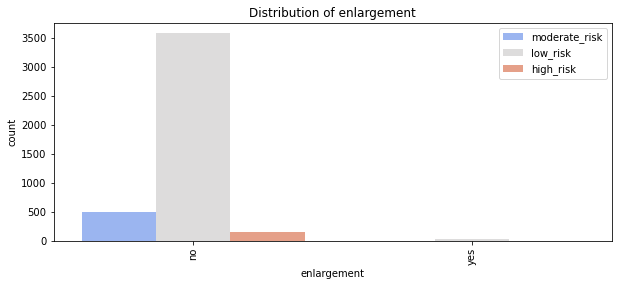

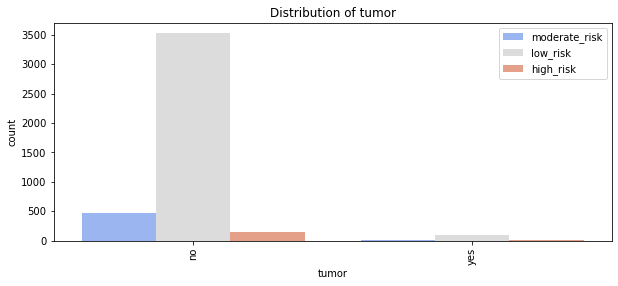

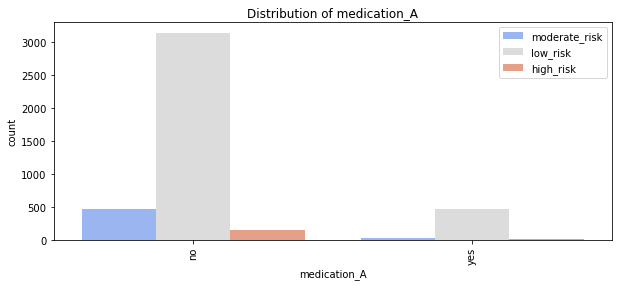

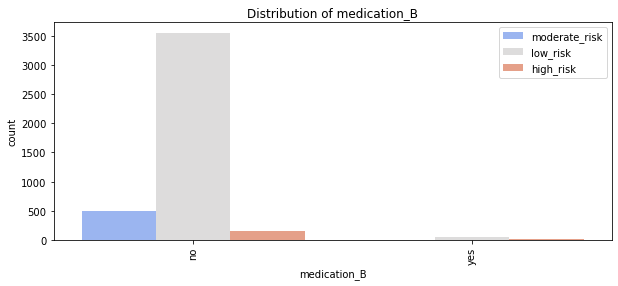

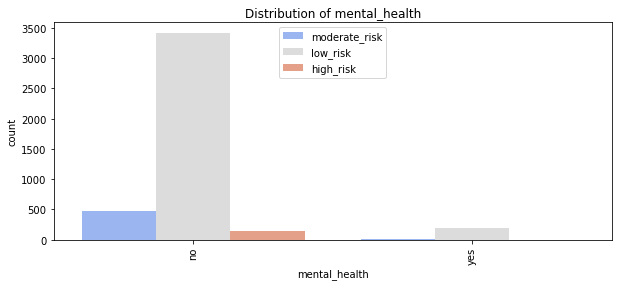

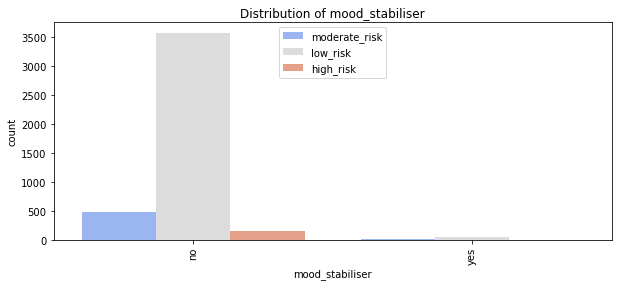

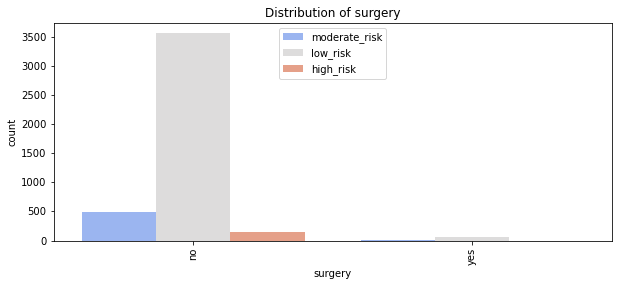

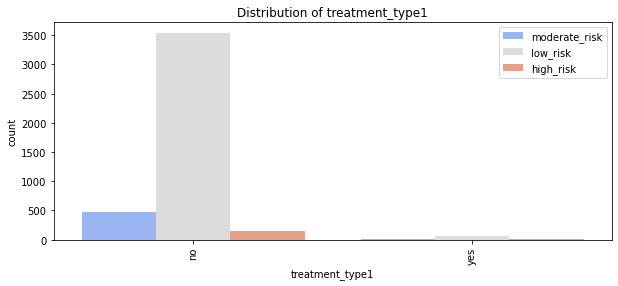

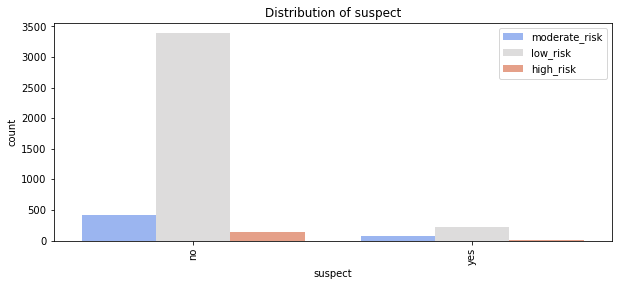

In [10]:
for column in categorical_features:
    if column in ["id", "disorder", "target"]:
        continue
    #make sure that plot only takes the two plots below by using the following command
    plt.figure(figsize=(10,4))
    plt.xticks(rotation=90) 
    sns.countplot(x=column, hue='target', palette="coolwarm", data=train_data)
    #include a legend
    plt.legend()
    #include a dynamic title
    plt.title("Distribution of " +column)
    #Save the plot to the working directory
    plt.savefig(data_folder+column+'.jpg')

### Numerical Column Distribution Visualisation
Boxplots can be plotted using a categorical column against all numerical columns by changing the value of the `cat` variable. The categorical columns that can be used are `gender`, `sick`, `pregnant`, `concern_type1`, `concern_type2`, `enlargement`, `tumor`, `medication_A`, `medication_B`, `mental_health`, `mood_stabiliser`, `surgery`, `treatment_type1`, `suspect`.

The `gender` feature is used here as the plots above show `gender` having a more visible variation and there are clearly a fair amount of outliers for all the numerical features which will need to be handled during preprocessing. Especially `age` where one outlier causes the boxplot to be unreadable.

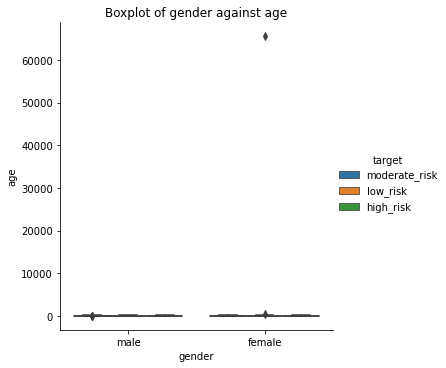

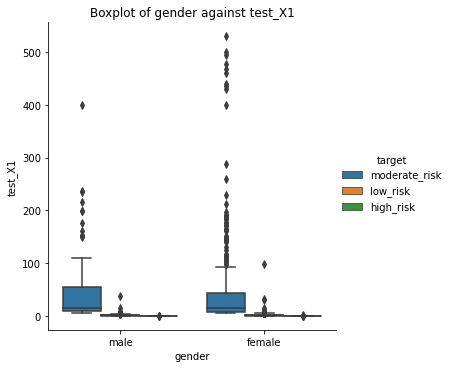

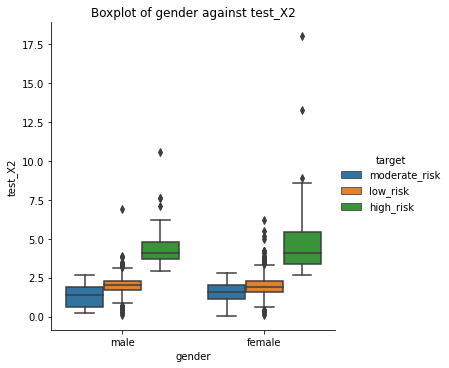

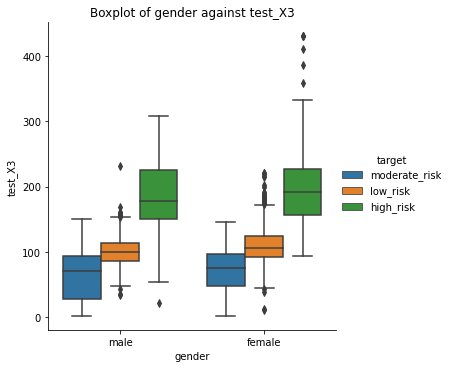

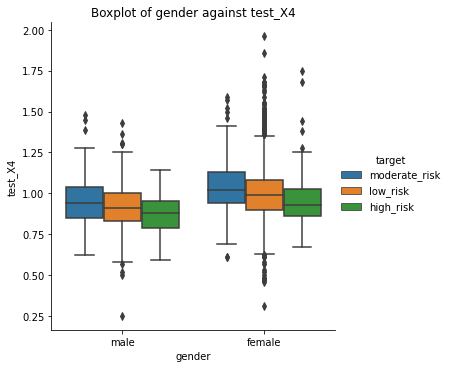

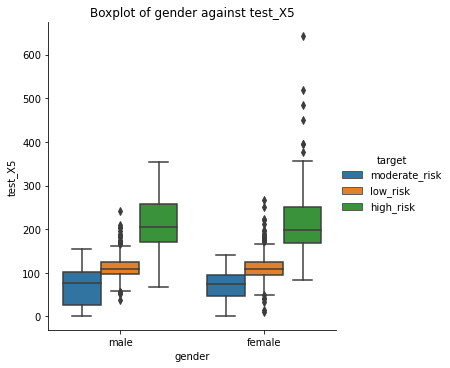

In [11]:
cat = "gender"
for num in numerical_features:
    if num == "test_X6" or cat in ["id", "disorder", "target"]:
        continue
    sns.catplot(x=cat, y=num, hue="target",  kind="box", data=train_data)
    #include a dynamic title
    plt.title("Boxplot of " + cat + " against " + num)
    #Save the plot to the working directory
    plt.savefig(data_folder + cat + "_vs_"+ num +'.jpg')

Check for the outrageous `age` outliers in the train and test data. Let's assume 100 is the maximum age.

In [12]:
print("Train data:")
print(train_data[["id", "age"]][train_data["age"] > 100])
print("\nTest Data:")
print(test_data[["id", "age"]][train_data["age"] > 100])

Train data:
          id    age
2459  PA3460  65526
3477  PA4478    455

Test Data:
Empty DataFrame
Columns: [id, age]
Index: []


C:\Users\User\AppData\Local\Temp\ipykernel_20304\1513058195.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(test_data[["id", "age"]][train_data["age"] > 100])


### Correlation Visualisation Heatmap
The cell below visualises a correlation matrix heatmap of the numerical values and the `target` column that has been encoded. Based on the heatmap, there does not seem seem to be any correlation between medical diagnosis (`target`) and `age` or `test_X6`. However, due to the 2 huge outliers in the `age` feature, it is possible that the observations are affecting the correlation.

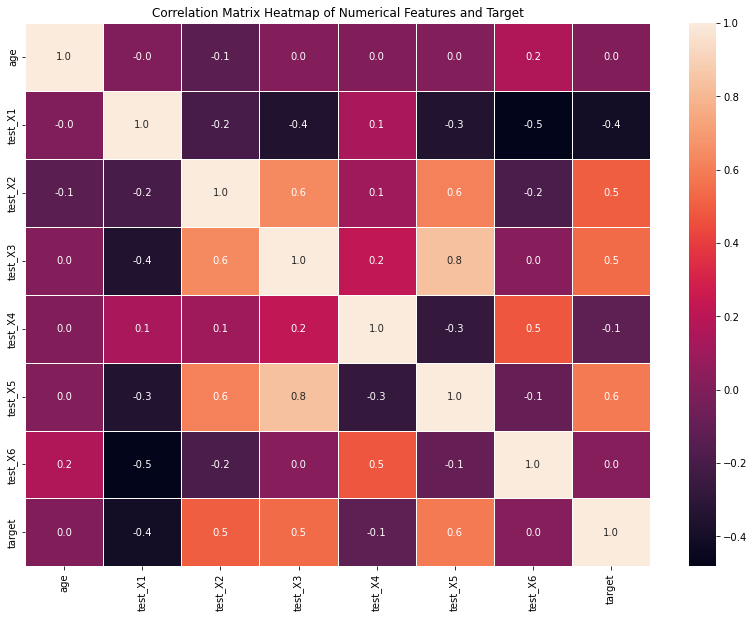

In [13]:
data = train_data[numerical_features + ["target"]]
encoder = ce.OrdinalEncoder(cols="target", handle_missing='return_nan', return_df=True)
data = encoder.fit_transform(data)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
a = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", linewidths=.7)

# Set feature names for both axes
a.set_xticklabels(correlation_matrix.columns, rotation=90)
a.set_yticklabels(correlation_matrix.columns)

plt.title('Correlation Matrix Heatmap of Numerical Features and Target')
plt.savefig(data_folder + "num_and_target_corr_mat_heatmap.jpg")
plt.show()

After removing the observations with the extreme outliers in `age` and creating the heat map again, the correlation only has a small change. This means that age will not be a useful feature for the model.

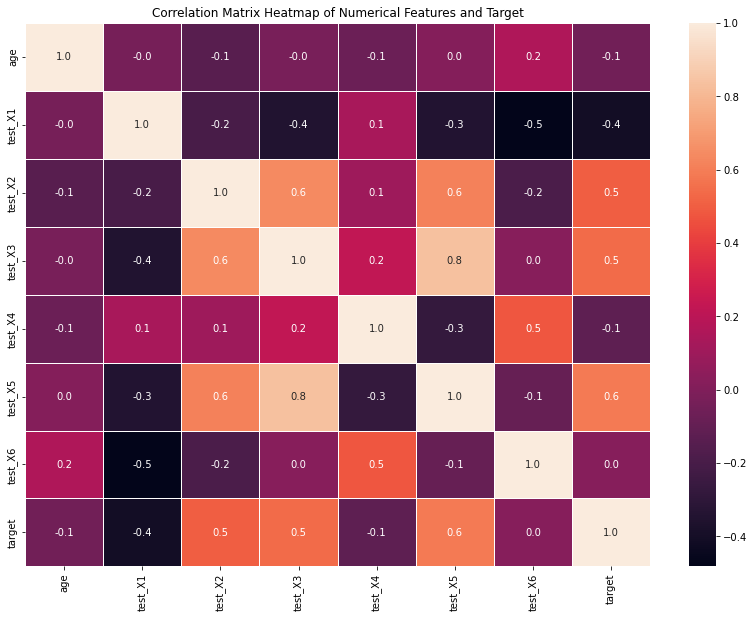

In [14]:
temp = train_data[train_data["age"] <= 100]
data = temp[numerical_features + ["target"]]
encoder = ce.OrdinalEncoder(cols="target", handle_missing='return_nan', return_df=True)
data = encoder.fit_transform(data)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = data.corr()
a = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", linewidths=.7)

# Set feature names for both axes
a.set_xticklabels(correlation_matrix.columns, rotation=90)
a.set_yticklabels(correlation_matrix.columns)

plt.title('Correlation Matrix Heatmap of Numerical Features and Target')
plt.savefig(data_folder + "num_and_target_corr_mat_heatmap_no_age_outlier.jpg")
plt.show()

After removing the outrageous outliers from `age`, the boxplot has a better visual. 

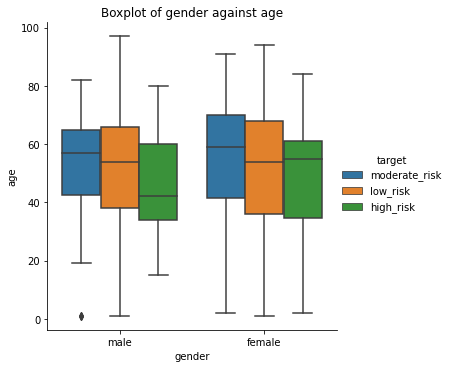

In [15]:
sns.catplot(x="gender", y="age", hue="target",  kind="box", data=temp)
#include a dynamic title
plt.title("Boxplot of " + "gender" + " against " + "age")
#Save the plot to the working directory
plt.savefig(data_folder + 'gender_vs_age_no_outlier.jpg')

## 2. Data Cleansing and Pre-processing

### Remove the unnecessary columns
The first thing to do is removing the features that are considered to not have an effect on the prediction. The features to drop are:
1. `id` : All values are unique
2. `age`: Little to no correlation to target
3. `text_X6` : Too many missing values
4. `disorder` : All values are constant 
5. `suspect` : Speculation by patients and does not relate to physical or mental state, it is safe to assume that it is a feature not worth exploring. 

In [16]:
# Remove columns from train and test data
train_data.drop(columns=["id", "age", "test_X6", "disorder", "suspect"], inplace=True)
test_data.drop(columns=["id", "age", "test_X6", "disorder", "suspect"], inplace=True)
# Remove the column names from the list as well
categorical_features = [item for item in categorical_features if item not in ["id", "age", "disorder", "suspect"]]
numerical_features = [item for item in numerical_features if item not in ["age", "test_X6"]]

In [17]:
print(f"categorical_features = {categorical_features}")
print(f"numerical_features = {numerical_features}")
# Check if columns have been removed from dataframe
print("train_data: ")
print(train_data.columns)
print("test_data: ")
print(test_data.columns)

categorical_features = ['gender', 'sick', 'pregnant', 'concern_type1', 'concern_type2', 'enlargement', 'tumor', 'medication_A', 'medication_B', 'mental_health', 'mood_stabiliser', 'surgery', 'treatment_type1']
numerical_features = ['test_X1', 'test_X2', 'test_X3', 'test_X4', 'test_X5']
train_data: 
Index(['gender', 'sick', 'pregnant', 'test_X1', 'test_X2', 'test_X3',
       'test_X4', 'test_X5', 'concern_type1', 'concern_type2', 'enlargement',
       'tumor', 'medication_A', 'medication_B', 'mental_health',
       'mood_stabiliser', 'surgery', 'treatment_type1', 'target'],
      dtype='object')
test_data: 
Index(['gender', 'sick', 'pregnant', 'test_X1', 'test_X2', 'test_X3',
       'test_X4', 'test_X5', 'concern_type1', 'concern_type2', 'enlargement',
       'tumor', 'medication_A', 'medication_B', 'mental_health',
       'mood_stabiliser', 'surgery', 'treatment_type1'],
      dtype='object')


### Get Target Labels
Before `train_data` can be split, the target labels of `train_data` have to be extracted and the `target` column will be dropped.

In [18]:
train_labels = train_data["target"]
train_data.drop(columns="target", inplace=True)
print(train_labels)

0       moderate_risk
1            low_risk
2       moderate_risk
3            low_risk
4            low_risk
            ...      
4245         low_risk
4246    moderate_risk
4247         low_risk
4248         low_risk
4249         low_risk
Name: target, Length: 4250, dtype: object


### Splitting the Data
Once the labels have been separated from the dataset, the next thing to do is to split the train data into train and validation sets. The random state is used for reproducibility and `train_test_split` will be stratified so that proportion of target labels will be the same as the original dataset. 

In [19]:
# Assuming 'X' is feature matrix and 'y' is target variable
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.3, 
                                                      random_state=35, stratify=train_labels)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_valid, return_counts=True))

(array(['high_risk', 'low_risk', 'moderate_risk'], dtype=object), array([ 104, 2529,  342], dtype=int64))
(array(['high_risk', 'low_risk', 'moderate_risk'], dtype=object), array([  45, 1083,  147], dtype=int64))


### Data Imputation
The `DataFrameImputer` class is used to impute both the categorical and numerical columns. Since there are both categorical and numerical features containing missing values, both types of features will need to be handled separately. 

### Categorical imputing 
There is a choice between imputing and removing the missing values. As test data contains missing categorical values and all its samples need to have a predicted label, removing rows will not be used.

### Numerical Imputing
`test_X1` to `test_X5` all have missing values. They will be imputed using mean or median of the other values.
`num_impute_type` variable determines how the missing values are handled.

0 = Missing values are imputed using mean of each column.

1 = Missing values are imputed using median of each column.

In [20]:
class DataFrameImputer(TransformerMixin):

    def __init__(self, num_impute_type=0):
        """Impute missing values.

        Columns of dtype object are imputed with most frequent value

        Columns of other types are imputed with mean of column, or median of column. [0, 1]

        """
        self.fill = None
        self.num_impute = num_impute_type
            
        
    def fit(self, X):
        # Create a temporary new X dataframe
        new_X = X.copy()
        # Stores columns with the same data type
        cols = []
        # Value to be imputed in each column following cols
        impute_vals = []
        # Go through each column and find those that are categorical
        for col in new_X:
            if new_X[col].dtype == np.dtype('O'):
                # Append the name of the categorical column into cols
                cols.append(col)
                impute_vals.append(new_X[col].value_counts().index[0])
        # Save the imputation values into a Series
        self.fill = pd.Series(impute_vals, index=cols)
        
        # Empty the lists for numerical now
        cols = []
        impute_vals = []
        
        for col in new_X:
            if new_X[col].dtype != np.dtype('O'):
                cols.append(col)
                if self.num_impute: 
                    impute_vals.append(new_X[col].median())
                else: 
                    impute_vals.append(new_X[col].mean())
        
        self.fill = self.fill.append(pd.Series(impute_vals, index=cols))        
            
        return self
    

    def transform(self, X):
        return X.fillna(self.fill)
        

In [21]:
df_imputer = DataFrameImputer(num_impute_type=1)
df_imputer.fit(X_train)
print('X_train before...')
# print(X_train)
#Let us see missing value for the train data before
missing_val_count_by_column = X_train.isnull().sum()
print('Missing columns for the X_train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

X_train = df_imputer.transform(X_train)

print('\nX_train after...')
# print(X_train)
#Let us see missing value for the train data after
missing_val_count_by_column = X_train.isnull().sum()
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

print("\n-------------------------------------------------------------------")

print('\nX_valid before...')
# print(X_valid)
missing_val_count_by_column = X_valid.isnull().sum()
print('Missing columns for the X_valid data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

X_valid = df_imputer.transform(X_valid)

print('\nX_valid after...')
# print(X_valid)
missing_val_count_by_column = X_valid.isnull().sum()
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

print("\n-------------------------------------------------------------------")

print('\ntest_data before...')
missing_val_count_by_column = test_data.isnull().sum()
print('Missing columns for the test_data:\n',missing_val_count_by_column[missing_val_count_by_column>0])

test_data = df_imputer.transform(test_data)

print('\ntest_data after...')
# print(X_valid)
missing_val_count_by_column = test_data.isnull().sum()
print('Missing columns for the Train data:\n',missing_val_count_by_column[missing_val_count_by_column>0])


X_train before...
Missing columns for the X_train data:
 gender     102
test_X1    292
test_X2    859
test_X3    146
test_X4    273
test_X5    272
dtype: int64

X_train after...
Missing columns for the Train data:
 Series([], dtype: int64)

-------------------------------------------------------------------

X_valid before...
Missing columns for the X_valid data:
 gender      39
test_X1    119
test_X2    384
test_X3     70
test_X4    119
test_X5    115
dtype: int64

X_valid after...
Missing columns for the Train data:
 Series([], dtype: int64)

-------------------------------------------------------------------

test_data before...
Missing columns for the test_data:
 gender      26
test_X1     76
test_X2    208
test_X3     33
test_X4     72
test_X5     71
dtype: int64

test_data after...
Missing columns for the Train data:
 Series([], dtype: int64)


C:\Users\User\AppData\Local\Temp\ipykernel_20304\2883223464.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.fill = self.fill.append(pd.Series(impute_vals, index=cols))


### Balancing the Data
The cell below will sample the data with a technique in order to balance the dataset depending on the `sample_type` variable. 

0 = No balancing of the data

1 = Oversampling using `SMOTENC` which handles dataset with both categorical and numerical features


In [22]:
# Display the class counts before balancing
print("Class Counts Before Balancing:")
print(np.unique(y_train, return_counts=True))

sampler = None
sample_type = 1

if sample_type:
    sampler = SMOTENC(categorical_features=categorical_features, random_state=35)
    balanced_X_train, balanced_y_train = sampler.fit_resample(X_train, y_train)
else:
    balanced_X_train = X_train.copy()
    balanced_y_train = y_train.copy()

# Display the class counts after balancing
print("\nClass Counts After Balancing:")
print(np.unique(balanced_y_train, return_counts=True))

Class Counts Before Balancing:
(array(['high_risk', 'low_risk', 'moderate_risk'], dtype=object), array([ 104, 2529,  342], dtype=int64))

Class Counts After Balancing:
(array(['high_risk', 'low_risk', 'moderate_risk'], dtype=object), array([2529, 2529, 2529], dtype=int64))


### Encode categorical columns and target labels

In [23]:
print(balanced_X_train)
enc = ce.OrdinalEncoder(cols=categorical_features, handle_missing='return_nan', return_df=True)
enc.fit(X_train)
encoded_X_train = enc.transform(balanced_X_train)
encoded_X_valid = enc.transform(X_valid)
encoded_test_data = enc.transform(test_data)
print(encoded_X_train)
# encoded_train_data = enc.fit_transform(train_data)
# encoded_test_data = enc.fit_transform(test_data)

      gender sick pregnant     test_X1   test_X2     test_X3   test_X4  \
0       male   no       no    0.800000  2.600000  113.000000  0.910000   
1     female   no       no    0.510000  1.900000  118.000000  1.150000   
2       male   no       no    1.000000  2.200000   95.000000  0.960000   
3     female   no       no    2.800000  1.900000  123.000000  1.160000   
4       male   no       no    0.210000  3.800000  168.000000  0.980000   
...      ...  ...      ...         ...       ...         ...       ...   
7582  female   no       no    7.679874  2.285004   80.925020  0.996373   
7583  female   no       no  516.802257  1.974620   18.883096  1.165684   
7584  female   no       no    6.561943  1.845708   97.638057  0.861717   
7585    male   no       no    9.090183  2.206258   89.482209  0.960000   
7586    male   no       no   15.236240  1.938188   86.872707  0.910000   

         test_X5 concern_type1 concern_type2 enlargement tumor medication_A  \
0     123.000000            no  

In [24]:
le = LabelEncoder()
le.fit(y_train)
encoded_y_train = le.transform(balanced_y_train)
encoded_y_valid = le.transform(y_valid)
print(np.unique(encoded_y_train, return_counts=True))
# test = le.inverse_transform(encoded_labels)

(array([0, 1, 2]), array([2529, 2529, 2529], dtype=int64))


https://stats.stackexchange.com/questions/320085/when-imputing-missing-values-in-a-test-set-should-the-new-values-come-from-the

https://stats.stackexchange.com/questions/344571/imputing-the-mean-value-from-the-train-set-into-the-test-set

## 3. Supervised Model Training, Tuning, and Evaluation

For the model training, each classifier uses the `GridSearchCV` to get the best parameter combinations for each model's best performance.

### Transformer Types

In [25]:
transformer_types = ["passthrough", StandardScaler(), Normalizer()]

### Decision Trees

In [26]:
# dt_params = (DecisionTreeClassifier, {'criterion': ['gini', 'entropy'], 
#                                       'max_depth': [None, 10, 20, 30], 
#                                       'min_samples_split': [2, 5, 10], 
#                                       'min_samples_leaf': [1, 2, 4]})
dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

clfs = [DecisionTreeClassifier(random_state=35, **para) for para in ParameterGrid(dt_params)]
dt_pipeline = Pipeline(
    [
        ("transformer", "passthrough"),
        ("clf", DecisionTreeClassifier)
    ]
)

dt_pipeline_params = {
    "transformer": transformer_types,
    "clf": clfs
}

# grid_cv = GridSearchCV(pipeline, dt_params)
# grid_cv.fit(encoded_X_train, encoded_y_train)
# score = grid_cv.score(encoded_X_valid, encoded_y_valid)
# print(score)
# print(grid_cv.best_params_)

### Random Forest

In [27]:
rf_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

clfs = [RandomForestClassifier(random_state=35, **para) for para in ParameterGrid(rf_params)]
rf_pipeline = Pipeline(
    [
        ("transformer", "passthrough"),
        ("clf", RandomForestClassifier)
    ]
)
rf_pipeline_params = {
    "transformer": transformer_types,
    "clf": clfs
}

# grid_cv = GridSearchCV(rf_pipeline, rf_params)
# grid_cv.fit(encoded_X_train, encoded_y_train)
# score = grid_cv.score(encoded_X_valid, encoded_y_valid)
# print(score)
# print(grid_cv.best_params_)


### K-Nearest Neighbours

In [28]:
knn_params = {
    'n_neighbors': [1, 3, 5, 7], 
    'algorithm': ['ball_tree', 'kd_tree'], 
    'metric': ['euclidean', 'manhattan']
}

clfs = [KNeighborsClassifier(**para) for para in ParameterGrid(knn_params)]
knn_pipeline = Pipeline(
    [
        ("transformer", "passthrough"),
        ("clf", KNeighborsClassifier)
    ]
)
knn_pipeline_params = {
    "transformer": transformer_types,
    "clf": clfs
}

# grid_cv = GridSearchCV(knn_pipeline, knn_params)
# grid_cv.fit(encoded_X_train, encoded_y_train)
# score = grid_cv.score(encoded_X_valid, encoded_y_valid)
# print(score)
# print(grid_cv.best_params_)


### Support Vector Machine (SVM)

In [29]:

svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"], 
    "C": [0.001, 0.01, 0.1, 1.0]
}

clfs = [SVC(**para) for para in ParameterGrid(svm_params)]
svm_pipeline = Pipeline(
    [
        ("transformer", "passthrough"),
        ("clf", SVC)
    ]
)
svm_pipeline_params = {
    "transformer": transformer_types,
    "clf": clfs
}

# grid_cv = GridSearchCV(svm_pipeline, svm_params)
# grid_cv.fit(encoded_X_train, encoded_y_train)
# score = grid_cv.score(encoded_X_valid, encoded_y_valid)
# print(score)
# print(grid_cv.best_params_)


### Logistic Regression

In [30]:
lr_params = {
    "penalty" : ["l1", "l2", "elasticnet", "none"], 
    "C": [0.01, 0.1, 1.0]
}

clfs = [LogisticRegression(**para) for para in ParameterGrid(lr_params)]
lr_pipeline = Pipeline(
    [
        ("transformer", "passthrough"),
        ("clf", LogisticRegression)
    ]
)
lr_pipeline_params = {
    "transformer": transformer_types,
    "clf": clfs
}

# grid_cv = GridSearchCV(lr_pipeline, lr_params)
# grid_cv.fit(encoded_X_train, encoded_y_train)
# score = grid_cv.score(encoded_X_valid, encoded_y_valid)
# print(score)
# print(grid_cv.best_params_)

Pipeline is used here for all of the classifiers going through each parameters

In [31]:
pipelines = [dt_pipeline, rf_pipeline, knn_pipeline, svm_pipeline, lr_pipeline]
pipeline_params = [dt_pipeline_params, rf_pipeline_params, knn_pipeline_params, svm_pipeline_params, lr_pipeline_params]

best_classifiers_validation_results = {
    0: ("Decision Tree", {}),
    1: ("Random Forest", {}),
    2: ("K-Nearest Neighbors", {}),
    3: ("Support Vector Machine", {}),
    4: ("Logistic Regression", {})
}

for i in range(len(pipelines)):
    print(best_classifiers_validation_results[i][0])
    grid_cv = GridSearchCV(pipelines[i], pipeline_params[i])
    grid_cv.fit(encoded_X_train, encoded_y_train)
    encoded_pred_labels = grid_cv.predict(encoded_X_valid)
    accuracy = accuracy_score(encoded_y_valid, encoded_pred_labels)
    balanced_accuracy = balanced_accuracy_score(encoded_y_valid, encoded_pred_labels)
    precision = precision_score(encoded_y_valid, encoded_pred_labels, average=None)
    recall = recall_score(encoded_y_valid, encoded_pred_labels, average=None)
    f_1 = f1_score(encoded_y_valid, encoded_pred_labels, average=None)
    best_classifiers_validation_results[i][1]["Best Params"] = grid_cv.best_params_
    best_classifiers_validation_results[i][1]["Accuracy"] = accuracy
    best_classifiers_validation_results[i][1]["Balanced Accuracy"] = balanced_accuracy
    best_classifiers_validation_results[i][1]["Precision"] = precision
    best_classifiers_validation_results[i][1]["Recall"] = recall
    best_classifiers_validation_results[i][1]["F1"] = f_1

Decision Tree
Random Forest
K-Nearest Neighbors
Support Vector Machine
Logistic Regression


C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepro

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

In [32]:
best_classifiers_validation_results

{0: ('Decision Tree',
  {'Best Params': {'clf': DecisionTreeClassifier(min_samples_leaf=2, random_state=35),
    'transformer': 'passthrough'},
   'Accuracy': 0.9835294117647059,
   'Balanced Accuracy': 0.9553390577529873,
   'Precision': array([0.80392157, 0.99166667, 0.98611111]),
   'Recall': array([0.91111111, 0.98891967, 0.96598639]),
   'F1': array([0.85416667, 0.99029126, 0.97594502])}),
 1: ('Random Forest',
  {'Best Params': {'clf': RandomForestClassifier(bootstrap=False, criterion='entropy',
                           min_samples_split=5, random_state=35),
    'transformer': 'passthrough'},
   'Accuracy': 0.9874509803921568,
   'Balanced Accuracy': 0.9769565936562374,
   'Precision': array([0.86      , 0.99627907, 0.96666667]),
   'Recall': array([0.95555556, 0.98891967, 0.98639456]),
   'F1': array([0.90526316, 0.99258573, 0.97643098])}),
 2: ('K-Nearest Neighbors',
  {'Best Params': {'clf': KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=1),
    

For this cell, the same is used but instead of using `Normalizer`, `normalize` is used that normalises the data along the features rather than along the samples.

In [33]:
feat_norm_X_train = normalize(encoded_X_train, axis=0)
feat_norm_X_valid = normalize(encoded_X_valid, axis=0)

feature_norm_best_validation_results = {
    0: ("Decision Tree", {}),
    1: ("Random Forest", {}),
    2: ("K-Nearest Neighbors", {}),
    3: ("Support Vector Machine", {}),
    4: ("Logistic Regression", {})
}

feature_norm_clfs = [DecisionTreeClassifier(random_state=35), RandomForestClassifier(random_state=35), 
                     KNeighborsClassifier(), SVC(), LogisticRegression()]
feature_norm_params = [dt_params, rf_params, knn_params, svm_params, lr_params]

for i in range(len(feature_norm_clfs)):
    grid_cv = GridSearchCV(feature_norm_clfs[i], feature_norm_params[i])
    grid_cv.fit(feat_norm_X_train, encoded_y_train)
    encoded_pred_labels = grid_cv.predict(feat_norm_X_valid)
    accuracy = accuracy_score(encoded_y_valid, encoded_pred_labels)
    balanced_accuracy = balanced_accuracy_score(encoded_y_valid, encoded_pred_labels)
    precision = precision_score(encoded_y_valid, encoded_pred_labels, average=None)
    recall = recall_score(encoded_y_valid, encoded_pred_labels, average=None)
    f_1 = f1_score(encoded_y_valid, encoded_pred_labels, average=None)
    feature_norm_best_validation_results[i][1]["Best Params"] = grid_cv.best_params_
    feature_norm_best_validation_results[i][1]["Accuracy"] = accuracy
    feature_norm_best_validation_results[i][1]["Balanced Accuracy"] = balanced_accuracy
    feature_norm_best_validation_results[i][1]["Precision"] = precision
    feature_norm_best_validation_results[i][1]["Recall"] = recall
    feature_norm_best_validation_results[i][1]["F1"] = f_1
    
    confusion_matrix(encoded_y_valid, encoded_pred_labels)


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

In [34]:
feature_norm_best_validation_results

{0: ('Decision Tree',
  {'Best Params': {'criterion': 'gini',
    'max_depth': None,
    'min_samples_leaf': 2,
    'min_samples_split': 2},
   'Accuracy': 0.8658823529411764,
   'Balanced Accuracy': 0.3919715747179142,
   'Precision': array([0.5       , 0.86538462, 0.92      ]),
   'Recall': array([0.02222222, 0.99722992, 0.15646259]),
   'F1': array([0.04255319, 0.92664093, 0.26744186])}),
 1: ('Random Forest',
  {'Best Params': {'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 10},
   'Accuracy': 0.8635294117647059,
   'Balanced Accuracy': 0.37414965986394555,
   'Precision': array([0.        , 0.86157518, 1.        ]),
   'Recall': array([0.        , 1.        , 0.12244898]),
   'F1': array([0.        , 0.92564103, 0.21818182])}),
 2: ('K-Nearest Neighbors',
  {'Best Params': {'algorithm': 'ball_tree',
    'metric': 'manhattan',
    'n_neighbors': 1},
   'Accuracy': 0.11215686274509803,
   'Balanced Accuracy': 

### Balanced best model evaluation

In [48]:
best_model = RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_split=5, random_state=35)

best_model.fit(encoded_X_train, encoded_y_train)
print(f"Training set score: {best_model.score(encoded_X_train, encoded_y_train)}")
print(f"Validation set score: {best_model.score(encoded_X_valid, encoded_y_valid)}")
# pred_valid_labels = le.inverse_transform(encoded_pred_valid_labels)
# pred_df["predicted_target"] = encoded_pred_labels
# pred_df.to_csv("predictedTarget.csv", index=False)

Training set score: 1.0
Validation set score: 0.9874509803921568


### Imbalanced best model evaluation

In [36]:
imbalanced_best_model = DecisionTreeClassifier(min_samples_split=5)
imbalanced_best_model_pipeline = Pipeline(
    [
        ("transformer", StandardScaler()), 
        ("clf", imbalanced_best_model)
    ]
)
imbalanced_best_model_pipeline.fit(encoded_X_train, encoded_y_train)

imbalanced_best_model_pipeline.fit(encoded_X_train, encoded_y_train)
print(f"Training set score: {imbalanced_best_model_pipeline.score(encoded_X_train, encoded_y_train)}")
print(f"Validation set score: {imbalanced_best_model_pipeline.score(encoded_X_valid, encoded_y_valid)}")

# pred_df["predicted_target"] = encoded_pred_labels
# pred_df.to_csv("predicted.csv", index=False)

Training set score: 0.9993409779886648
Validation set score: 0.9858823529411764


### Postprocessing Using SHAP 
To see which features were mainly used for the model, the SHAP library is used.

In [55]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(encoded_test_data)


low_risk = 0
moderate_risk = 1
high_risk = 2

shap_values_l = shap.Explanation(values=shap_values[low_risk], 
                                 data=encoded_test_data, feature_names=encoded_test_data.columns)
print('low_risk', np.shape(shap_values_l))

shap_values_m = shap.Explanation(values=shap_values[moderate_risk], 
                                 data=encoded_test_data, feature_names=encoded_test_data.columns)
print('moderate_risk', np.shape(shap_values_m))

shap_values_h = shap.Explanation(values=shap_values[high_risk], 
                                 data=encoded_test_data, feature_names=encoded_test_data.columns)
print('high_risk', np.shape(shap_values_l))

low_risk (18, 3)
moderate_risk (18, 3)
high_risk (18, 3)


### Prediction on Test Data with Best Model

In [37]:
encoded_pred_test_labels = best_model_pipeline.predict(encoded_test_data)

pred_test_labels = le.inverse_transform(encoded_pred_test_labels)
pred_df["predicted_target"] = pred_test_labels
pred_df.to_csv("predictedTarget.csv", index=False)

## Unsupervised Learning using Clustering Algorithms

### KMeans

In [44]:
numerical_X_train = encoded_X_train[numerical_features]

numerical_X_train = np.log1p(numerical_X_train)

print(numerical_X_train)

       test_X1   test_X2   test_X3   test_X4   test_X5
0     0.587787  1.280934  4.736198  0.647103  4.820282
1     0.412110  1.064711  4.779123  0.765468  4.644391
2     0.693147  1.163151  4.564348  0.672944  4.615121
3     1.335001  1.064711  4.820282  0.770108  4.672829
4     0.190620  1.568616  5.129899  0.683097  5.147494
...        ...       ...       ...       ...       ...
7582  2.161007  1.189368  4.405804  0.691332  4.412497
7583  6.249593  1.090116  2.989870  0.772736  2.770835
7584  2.023128  1.045812  4.591457  0.621499  4.755229
7585  2.311563  1.165104  4.505153  0.672944  4.682131
7586  2.787246  1.077793  4.475889  0.647103  4.564348

[7587 rows x 5 columns]


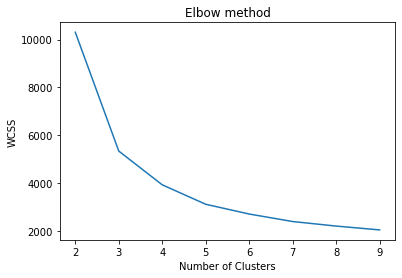

In [45]:
kmeans_models = [KMeans(n_clusters=k).fit(numerical_X_train) for k in range (2, 10)]
innertia = [model.inertia_ for model in kmeans_models]
plt.xticks([k for k in range (2, 10)])
plt.plot(range(2, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

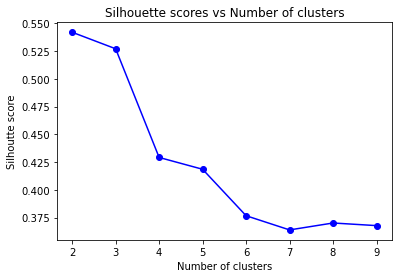

In [46]:
silhoutte_scores = [silhouette_score(numerical_X_train, model.labels_) for model in kmeans_models]
plt.plot([k for k in range (2, 10)], silhoutte_scores, "bo-")
plt.xticks([k for k in range (2, 10)])
plt.title('Silhouette scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(numerical_X_train)

print('Silhoutte score of KMeans with 3 clusters is ' + str(silhouette_score(encoded_X_train, kmeans.labels_)))

Silhoutte score of KMeans with 3 clusters is 0.5875227807127739
